In [360]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime

from keras.models import load_model

In [361]:
api_key = open('./../api_key.txt', 'r').read()

url = 'https://api.binance.com/api/v3/klines'

params = {
    'symbol':  'BTCUSDT',
    'interval': '1h',
    'limit': 720
}
headers = {
    'X-MBX-APIKEY': api_key
}

# Get current date, 4 years ago


results = requests.get(url, params=params)

In [362]:
data = pd.DataFrame(results.json())[[0, 1]]
data.columns = ['date', 'price']

In [363]:
data

,date,price
0,1679788800000,27462.96000000
1,1679792400000,27531.28000000
2,1679796000000,27593.34000000
3,1679799600000,27589.63000000
4,1679803200000,27529.27000000
...,...,...
715,1682362800000,27339.91000000
716,1682366400000,27383.28000000
717,1682370000000,27460.44000000
718,1682373600000,27414.64000000


In [364]:
prices = data['price']

In [365]:
prices

0      27462.96000000
1      27531.28000000
2      27593.34000000
3      27589.63000000
4      27529.27000000
            ...      
715    27339.91000000
716    27383.28000000
717    27460.44000000
718    27414.64000000
719    27463.86000000
Name: price, Length: 720, dtype: object

In [366]:
train_min = float(open('./../train_min_max_std/min.txt', 'r').read())
train_max = float(open('./../train_min_max_std/max.txt', 'r').read())

In [367]:
type(train_min), type(train_max)

(float, float)

In [368]:
prices_norm = (prices.astype(float) - train_min) / (train_max - train_min)

In [369]:
prices_norm = np.array(prices_norm)
prices_norm = prices_norm.reshape(1, 720, 1)
prices_norm

array([[[0.36171043],
        [0.36276959],
        [0.36373171],
        [0.36367419],
        [0.36273843],
        [0.36254232],
        [0.36297935],
        [0.36223304],
        [0.36236125],
        [0.36475273],
        [0.36517968],
        [0.3650538 ],
        [0.36795812],
        [0.36879171],
        [0.37236157],
        [0.36686144],
        [0.36699585],
        [0.36537393],
        [0.36752171],
        [0.3670712 ],
        [0.36736885],
        [0.36658874],
        [0.36752621],
        [0.37066059],
        [0.36954081],
        [0.3699473 ],
        [0.36735381],
        [0.36816276],
        [0.36831035],
        [0.36859405],
        [0.36562074],
        [0.36671633],
        [0.36707197],
        [0.3676879 ],
        [0.36888333],
        [0.36872427],
        [0.36837251],
        [0.36616024],
        [0.36527673],
        [0.35391897],
        [0.35303917],
        [0.35678902],
        [0.35391292],
        [0.35594086],
        [0.35405152],
        [0

In [370]:
model = load_model('saved_model.h5')

In [371]:
prediction_norm = model.predict(prices_norm)
prediction_norm

1/1 [==============================] - 1s 653ms/step


array([[0.35999277]], dtype=float32)

In [372]:
prediction = (prediction_norm * (train_max - train_min) + train_min)

In [373]:
prediction

array([[27352.164]], dtype=float32)

In [374]:
print(f'Next hour prediction: {prediction[0][0]}')

Next hour prediction: 27352.1640625


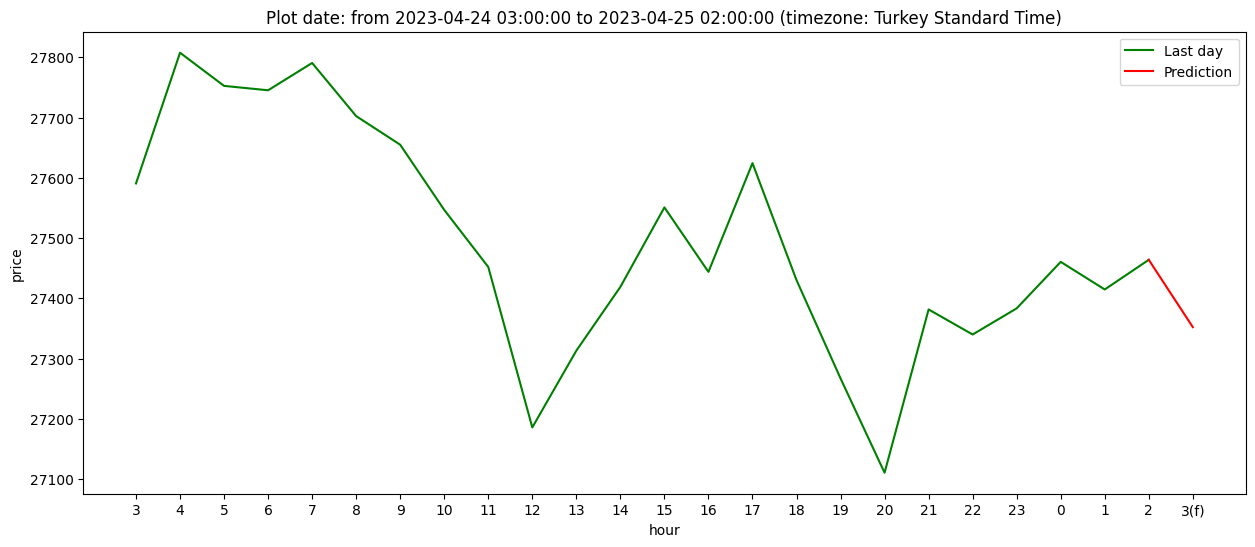

In [375]:
history_date_unix = data[696:]['date']
hours = []
for i in history_date_unix:
    hours.append(
        str(datetime.datetime.fromtimestamp(i / 1000).hour)
    )

history_y = prices[696:].values.astype(float)
history_x = hours

pred_y = [history_y[-1], prediction[0][0]]
if hours[-1] == '23':
    pred_x = ['23', '0']
else:
    pred_x = [hours[-1], str(int(hours[-1]) + 1) + '(f)']

plt.figure(figsize=(15, 6))
plt.plot(history_x, history_y, label='Last day', color='g')
plt.plot(pred_x, pred_y, label='Prediction',  color='r')
plt.legend()

date1 = datetime.datetime.fromtimestamp(history_date_unix[696] / 1000)
date2 = datetime.datetime.fromtimestamp(history_date_unix[719] / 1000)
timezone = datetime.datetime.now().astimezone().tzname()

plt.title(f'Plot date: from {date1} to {date2} (timezone: {timezone})')
plt.xlabel('hour')
plt.ylabel('price')

plt.savefig('plot_predicted.png')